In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random as ran
from functools import reduce
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from IPython.display import Markdown, display

In [2]:
# 1. load_excel
data_path = "data/apt_all.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

In [3]:
# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)
m.head()

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401,아파트1-101-1403,아파트1-101-1502,아파트1-101-1504,아파트1-101-1602,...,아파트4-104-101,아파트4-104-1301,아파트4-104-1501,아파트4-104-301,아파트4-105-102,아파트4-105-103,아파트4-105-1102,아파트4-105-1104,아파트4-105-601,아파트4-105-803
month,,,,,,,,,,,,,,,,,,,,,
1,253,689,183,239,455,343,380,219,389,350,...,335,363,181,216,270,518,230,279,161,156
2,251,481,177,218,397,297,339,197,348,288,...,309,339,146,184,267,344,208,236,167,150
3,255,424,203,222,378,303,349,202,357,368,...,313,372,152,236,268,417,212,272,166,155
4,252,355,180,230,368,278,298,188,346,365,...,266,346,149,210,268,421,208,243,156,148
5,230,357,258,203,414,270,418,156,320,265,...,305,256,151,222,287,349,185,284,165,180


In [4]:
m[m.columns[:6]]

,아파트1-101-1002,아파트1-101-104,아파트1-101-1102,아파트1-101-1202,아파트1-101-1302,아파트1-101-1401
month,,,,,,
1,253,689,183,239,455,343
2,251,481,177,218,397,297
3,255,424,203,222,378,303
4,252,355,180,230,368,278
5,230,357,258,203,414,270
6,212,363,272,207,411,275
7,326,423,416,204,597,350
8,431,454,450,207,701,411
9,207,334,198,188,445,299


In [5]:
predict_test = pd.DataFrame(columns=['실제 요금', '예측 요금', '오차'])
households_columns = list()

for _ in range(0, 1000):
    n = ran.randrange(50, len(m.columns) + 1)
    _m = m.sample(n=n, axis=1)
    _month = ran.randrange(1, 13)

    month_df = pd.DataFrame(_m.loc[_month])
    month_df.reset_index(inplace=True)
    month_df.columns = ['name', 'usage (kWh)']
    
    PUBLIC_PERCENTAGE = ran.randrange(10, 60)
    households_kWh = month_df['usage (kWh)'].sum()
    APT = round((households_kWh * 100) / (100 - PUBLIC_PERCENTAGE))
    
    # 예측 시뮬레이션
    pp = PublicPredictor(
        APT=APT,
        month_df=month_df,
        month=_month
    )

    predict_test = predict_test.append(pp.predict, ignore_index=True)
    households_columns.append((PUBLIC_PERCENTAGE,_month,month_df['name'].values))

In [6]:
max_err = predict_test['오차'].abs().max()
min_err = predict_test['오차'].abs().min()
predict_rate = predict_test.apply(lambda x: 
   x['예측 요금'] / x['실제 요금'] * 100 if x['실제 요금'] > x['예측 요금'] 
   else x['실제 요금'] / x['예측 요금'] * 100
   , axis=1).mean()
display(Markdown("# 공용부 요금 예측 시뮬레이션 결과 입니다.\n\n"))

print("• 최고 오차 : {}원".format(format(max_err,",")))
print("• 최소 오차 : {}원".format(format(min_err,",")))
print("• 평균 적중률 : {}%".format(format(predict_rate,",")))

predict_test.head()

# 공용부 요금 예측 시뮬레이션 결과 입니다.



• 최고 오차 : 4,450원
• 최소 오차 : 390원
• 평균 적중률 : 99.94608591129153%


,실제 요금,예측 요금,오차
0,1545730,1544490,1240
1,2998220,2995730,2490
2,2285160,2283400,1760
3,1501850,1500780,1070
4,1962880,1961150,1730


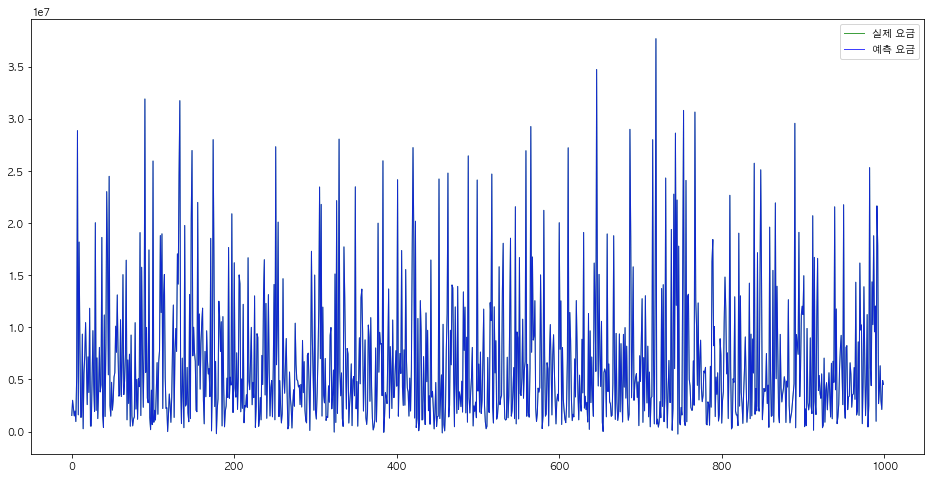

In [7]:
plt.figure(figsize=(16,8))

plt.plot(predict_test['실제 요금'], color='g', linewidth=1, label='실제 요금', alpha=0.75)
plt.plot(predict_test['예측 요금'], color='b', linewidth=1, label='예측 요금', alpha=0.75)

plt.legend(loc='upper right')

plt.show()